# Generation of MODIS Monthly Composites From Daily Dataset in DEA

**What does this notebook do?** 
This notebook demonstrates how to display a shapefile on top of a raster and how to calculate zonal statistics for a selected polygon from the raster data.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 25, Feb, 2019

**Author:** Zhi Huang

**Import modules**

In [1]:
%pylab notebook
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
import matplotlib.pyplot as plt
import shapefile as shpf
import fiona
import shapely
import ipywidgets as widgets
from ipywidgets import interact, fixed
from rasterstats import zonal_stats
from datacube.utils import geometry
#%matplotlib inline



Populating the interactive namespace from numpy and matplotlib


**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**design a query**

In [3]:
query = {'time':('2016-01-01','2016-01-05')}

**Load 5 days of SST (Sea Surface Temperature) data from Jan 2016, with full resolution (0.01 dd).**

In [4]:
data = dc.load(product='modis_oc_1d', measurements=('sst',), **query)

**load the same 5 days of SST data, only with resolution 0.1 dd. This data is only for display purpose as it loads faster with much less memory usage**

In [5]:
data1 = dc.load(product='modis_oc_1d', resolution=(0.1,0.1), measurements=('sst',), **query)

**Mask the nodata (-999) as 'nan'**

In [6]:
data = mask_invalid_data(data)

In [7]:
data1 = mask_invalid_data(data1)

**generate a 5-day composite to fill the data gap due to clouds**

In [8]:
data2 = data.resample(time='5D').mean()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
data4 = data1.resample(time='5D').mean()

In [17]:
data.crs

CRS('EPSG:4326')

**assign affine attribute for data2, used in the zonal statistic tool**

In [12]:
data2.attrs['crs']=data.crs

In [13]:
data2.affine

Affine(0.01, 0.0, 79.99,
       0.0, -0.01, 10.01)

**read the AMPs shapefile**

In [20]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/CMR_2013_dissolved.shp'

AMPs = shpf.Reader(poly_path)

**Plot the data, with colors stretch from vmin to vmax; and plot the AMPs polygons on top of the SST data** 

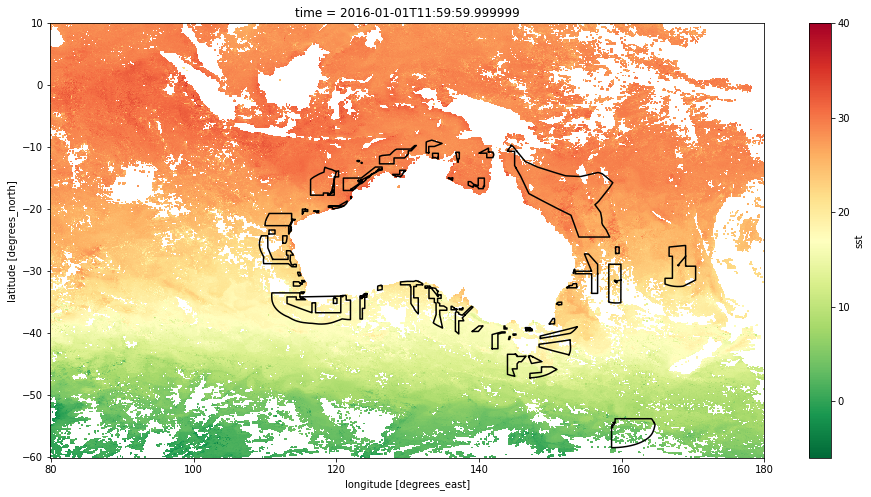

In [10]:
fig = plt.figure(figsize=(16,8))

data2.sst[0].plot(cmap='RdYlGn_r',vmin=-6,vmax=40)
for shape in AMPs.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()

**define and onclick event function. Calculate the zonal statistics from the 5-day SST composite for the selected AMP**

In [21]:
def onclick_polygon_interrogation(event):
    
    global pixelx, pixely, stats, Clickedpolygon
    pixelx, pixely = int(event.xdata), int(event.ydata)
    
    # Generate a point from the location
    Clickpoint = shapely.geometry.Point(pixelx, pixely)   
    AMPShapes = AMPs.shapes()
    
    # Find the polygon that contains the selected point
    Clickedpolygon = []
    for ix, shapes in enumerate(AMPs.shapes()):
        if shapely.geometry.shape(shapes).contains(Clickpoint) == True:
            Clickedpolygon.append(ix)
    
    # Colour the chosen polygon on the figure
    x = [i[0] for i in AMPShapes[Clickedpolygon[0]].points[:]]
    y = [i[1] for i in AMPShapes[Clickedpolygon[0]].points[:]]
    
    plt.figure(fig.number)
    plt.plot(x, y, 'r')
    
    # Grab the geometry from the polygon we want to interrogate
    with fiona.open(poly_path) as shapes:
        first_geometry = shapes[Clickedpolygon[0]]['geometry']
        
    
    # Do zonal statistics
    stats = zonal_stats(first_geometry,data2.sst[0].data,affine=data2.affine)
    

**setup displaying interface for user input (e.g.selection of an AMP for zonal statistics)**

<IPython.core.display.Javascript object>


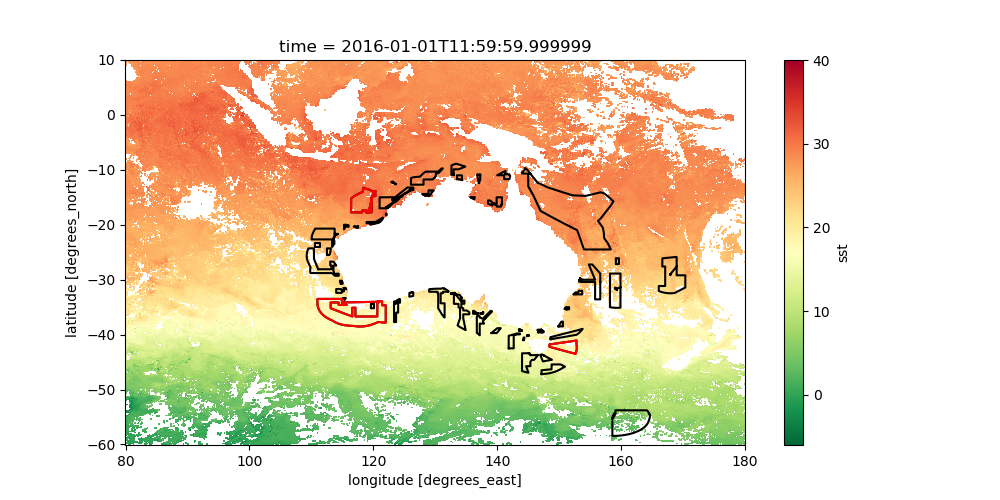

HTML(value='Click inside the polygon you would like to interrogate')

In [22]:
fig = plt.figure(figsize(10,5))

data4.sst[0].plot(cmap='RdYlGn_r',vmin=-6,vmax=40)
for shape in AMPs.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()
w = widgets.HTML("Click inside the polygon you would like to interrogate")

cid = fig.canvas.mpl_connect('button_press_event', onclick_polygon_interrogation)
display(w)


In [27]:
print(pixelx,pixely,Clickedpolygon)

118 -16 [3]


**display the result of the zonal stasitics**

In [28]:
stats

[{'min': 26.25,
  'max': 31.53499984741211,
  'mean': 29.028250682615433,
  'count': 86947}]